In [664]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [665]:
df = pd.read_csv("C:/Users/Joseph Rivera/Desktop/project/AI_projects/ml_poc/data/data.csv")
# df.set_index('ConversionID', inplace=True)
df.head()

,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup
0,@freewrytin God is way too good for Claritin,'1',"January 1, 2023",Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A
1,I need Claritin. So bad. When did I become cur...,'2',"February 2, 2023",Eric Santos,John Smith,Mack Valenzuela,3,25,Inbound,B
2,Thank god for Claritin.,'3',"March 3, 2023",Dan Trolly,Alex Trinidad,Virginia Simon,10,89,Outbound,C
3,And what's worse is that I reached my 3-day li...,'4',"April 4, 2023",Eric Santos,Dina Tuto,Mack Valenzuela,6,100,Inbound,D
4,Time to take some Claritin or Allegra or somet...,'5',"June 5, 2023",Eric Santos,Alex Trinidad,Mack Valenzuela,3,87,Outbound,A


In [666]:
# def split_train_test_by_date(df, date_column, train_size=0.8):
#     """
#     Splits a DataFrame into training and testing sets based on a date column.

#     Parameters:
#     df (pd.DataFrame): The DataFrame to split.
#     date_column (str): The name of the date column to sort by.
#     train_size (float): The proportion of the dataset to include in the training set (default is 0.8).

#     Returns:
#     pd.DataFrame, pd.DataFrame: The training and testing DataFrames.
#     """
#     # Ensure the DataFrame is sorted by the date column
#     df = df.sort_values(by=date_column)
    
#     # Determine the index for the split
#     split_index = int(len(df) * train_size)
    
#     # Split the DataFrame into training and testing sets
#     train_df = df.iloc[:split_index]
#     test_df = df.iloc[split_index:]
    
#     return train_df, test_df

# train_df, test_df = split_train_test_by_date(df, 'Date')


In [667]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Comments           130 non-null    object
 1   ConversionID       132 non-null    object
 2   Date               132 non-null    object
 3   Claim Manager      132 non-null    object
 4   Service Manager    132 non-null    object
 5   Officer Name       132 non-null    object
 6   NPS Score          132 non-null    int64 
 7   FCR Score          132 non-null    int64 
 8   Initial Direction  132 non-null    object
 9   Workgroup          132 non-null    object
dtypes: int64(2), object(8)
memory usage: 10.4+ KB


In [668]:
def clean_comments(df, column_name='Comments'):
    # Remove rows where the specified column is blank
    df = df[df[column_name].str.strip().astype(bool)]
    
    df = df[df[column_name].str.split().str.len() >= 3]
    
    return df

df = clean_comments(df, column_name='Comments')

In [669]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 0 to 131
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Comments           127 non-null    object
 1   ConversionID       127 non-null    object
 2   Date               127 non-null    object
 3   Claim Manager      127 non-null    object
 4   Service Manager    127 non-null    object
 5   Officer Name       127 non-null    object
 6   NPS Score          127 non-null    int64 
 7   FCR Score          127 non-null    int64 
 8   Initial Direction  127 non-null    object
 9   Workgroup          127 non-null    object
dtypes: int64(2), object(8)
memory usage: 10.9+ KB


In [670]:
def add_date_parts(df, date_column='Date'): 
    
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df[date_column] = pd.to_datetime(df[date_column], dayfirst=True)
    
    df['Year'] = df[date_column].dt.year
    df['Month'] = df[date_column].dt.month
    df['Quarter'] = df[date_column].dt.quarter
    
    return df

df = add_date_parts(df, date_column='Date')

In [671]:
def categorize_nps(score):
    if score < 0 or score > 10:
        return 'Unknown'  # Handle unexpected values
    if score <= 4:
        return 'Negative'
    elif score <= 6:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the function to the 'NPS Score' column and create a new column 'Sentiment'
df['Sentiment'] = df['NPS Score'].apply(categorize_nps)

In [672]:
df.head(1)

,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup,Year,Month,Quarter,Sentiment
0,@freewrytin God is way too good for Claritin,'1',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative


In [673]:
# df_final = df.copy()
# df_final.head()

In [674]:
def map_sentiment_to_int(df, sentiment):
    sentiment_mapping = {
        'Unknown':0,
        'Negative':0,
        'Neutral': 1,
        'Positive': 2,
    }
    df['Sentiment_int'] = df[sentiment].map(sentiment_mapping)
    return df

df = map_sentiment_to_int(df, 'Sentiment')

In [675]:
df.head()

,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup,Year,Month,Quarter,Sentiment,Sentiment_int
0,@freewrytin God is way too good for Claritin,'1',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0
1,I need Claritin. So bad. When did I become cur...,'2',2023-02-02,Eric Santos,John Smith,Mack Valenzuela,3,25,Inbound,B,2023,2,1,Negative,0
2,Thank god for Claritin.,'3',2023-03-03,Dan Trolly,Alex Trinidad,Virginia Simon,10,89,Outbound,C,2023,3,1,Positive,2
3,And what's worse is that I reached my 3-day li...,'4',2023-04-04,Eric Santos,Dina Tuto,Mack Valenzuela,6,100,Inbound,D,2023,4,2,Neutral,1
4,Time to take some Claritin or Allegra or somet...,'5',2023-06-05,Eric Santos,Alex Trinidad,Mack Valenzuela,3,87,Outbound,A,2023,6,2,Negative,0


In [676]:
def split_train_test_by_date(df, date, train_size=0.8):
    """
    Splits a DataFrame into training and testing sets based on a date column.

    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    date_column (str): The name of the date column to sort by.
    train_size (float): The proportion of the dataset to include in the training set (default is 0.8).

    Returns:
    pd.DataFrame, pd.DataFrame: The training and testing DataFrames.
    """
    # Ensure the DataFrame is sorted by the date column
    df = df.sort_values(by=date)
    
    # Determine the index for the split
    split_index = int(len(df) * train_size)
    
    # Split the DataFrame into training and testing sets
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    
    return train_df, test_df

train_df, test_df = split_train_test_by_date(df, 'Date')


In [677]:
train_df.head()

,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup,Year,Month,Quarter,Sentiment,Sentiment_int
0,@freewrytin God is way too good for Claritin,'1',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0
110,How do you freakin take the cotton ball out of...,'111',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,1,0,Outbound,A,2023,1,1,Negative,0
88,My grandma is worried about me bringing Clarit...,'89',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0
44,Chasing a claritin-d with a cran &amp; vodka i...,'45',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0
22,@HannahBlackwell do CLARITIN - D It did wonder...,'23',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,3,0,Outbound,A,2023,1,1,Negative,0


In [678]:
test_df.head()

,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup,Year,Month,Quarter,Sentiment,Sentiment_int
126,Ûª_Ûª_ÛªÕ@iSpeakComedy: If a girl sends yo...,'127',2024-07-17,Alice Wonderland,John Smith,Virginia Simon,3,16,Inbound,A,2024,7,3,Negative,0
16,@JonathanRKnight Better Claritin cos u won't s...,'17',2024-07-17,Alice Wonderland,John Smith,Virginia Simon,3,16,Inbound,A,2024,7,3,Negative,0
83,@kool_kayy you have a cold Hun. Lol I doubt it...,'84',2024-08-18,Eric Santos,Alex Trinidad,Mack Valenzuela,3,39,Outbound,B,2024,8,3,Negative,0
61,If she's sick..::I give her the Allegra-D whil...,'62',2024-08-18,Eric Santos,Alex Trinidad,Mack Valenzuela,2,39,Outbound,B,2024,8,3,Negative,0
39,@lexbdatbitch tell me about it I took a Benadr...,'40',2024-08-18,Eric Santos,Alex Trinidad,Mack Valenzuela,1,39,Outbound,B,2024,8,3,Negative,0


In [679]:
print(train_df.shape)
print(test_df.shape)

(101, 15)
(26, 15)


# Modeling

### Neural Network Original

<h4 style="color:red;">Training Data</h4>

In [680]:
# Constants for data preprocessing
max_length = 256  # Maximum length of the sequences
padding_type = 'post'  # Padding type for sequences shorter than the maximum length
vocab_size = 1000  # Size of the vocabulary used in the Embedding layer
embedding_dim=100  # Dimensionality of the embedding layer
hidden_units=100 # Number of hidden units in the LSTM layer
max_sequence_length = 100

In [681]:
def preprocess_text_data(df, text_column, label_column, vocab_size, max_length):
    # Extract texts and labels
    texts = df[text_column].values
    labels = df[label_column].values

    # Tokenize the text data
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad the sequences
    data = pad_sequences(sequences, maxlen=max_length)

    return data, labels, tokenizer

data_train, labels_train, tokenizer = preprocess_text_data(train_df, 'Comments', 'Sentiment_int', vocab_size=vocab_size, max_length=max_length)

In [682]:
def preprocess_data(data):
    return pad_sequences(data, maxlen=max_length, padding=padding_type )
train_data = preprocess_data(data_train)

In [683]:
# train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
# train_data = preprocess_data(train_data)
# test_data = preprocess_data(test_data)

In [684]:
def build_model(vocab_size, embedding_dim, hidden_units):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        GlobalAveragePooling1D(),
        Dense(hidden_units, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

In [685]:
# Build and compile the model
model = build_model(vocab_size, embedding_dim, hidden_units)
model.build(input_shape=(None, max_sequence_length))  # Replace max_sequence_length with the actual sequence length of your input
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train and evaluate the model
history = model.fit(data_train, labels_train, epochs=10, batch_size=32, verbose=2)
train_loss, train_acc = model.evaluate(train_data, labels_train, verbose=2)
print(f"Train Accuracy: {train_acc}, Train Loss: {train_loss}")


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 100)       │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_19     │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,403 (431.26 KB)

 Trainable params: 110,403 (431.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 - 1s - 146ms/step - accuracy: 0.6733 - loss: 0.8462
Epoch 2/10
4/4 - 0s - 6ms/step - accuracy: 0.9802 - loss: 0.1928
Epoch 3/10
4/4 - 0s - 8ms/step - accuracy: 0.9802 - loss: 0.1157
Epoch 4/10
4/4 - 0s - 8ms/step - accuracy: 0.9802 - loss: 0.1309
Epoch 5/10
4/4 - 0s - 7ms/step - accuracy: 0.9802 - loss: 0.1569
Epoch 6/10
4/4 - 0s - 22ms/step - accuracy: 0.9802 - loss: 0.1508
Epoch 7/10
4/4 - 0s - 8ms/step - accuracy: 0.9802 - loss: 0.1426
Epoch 8/10
4/4 - 0s - 9ms/step - accuracy: 0.9802 - loss: 0.1302
Epoch 9/10
4/4 - 0s - 8ms/step - accuracy: 0.9802 - loss: 0.1243
Epoch 10/10
4/4 - 0s - 7ms/step - accuracy: 0.9802 - loss: 0.1174
4/4 - 0s - 19ms/step - accuracy: 0.9802 - loss: 0.1128
Train Accuracy: 0.9801980257034302, Train Loss: 0.11278951168060303


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


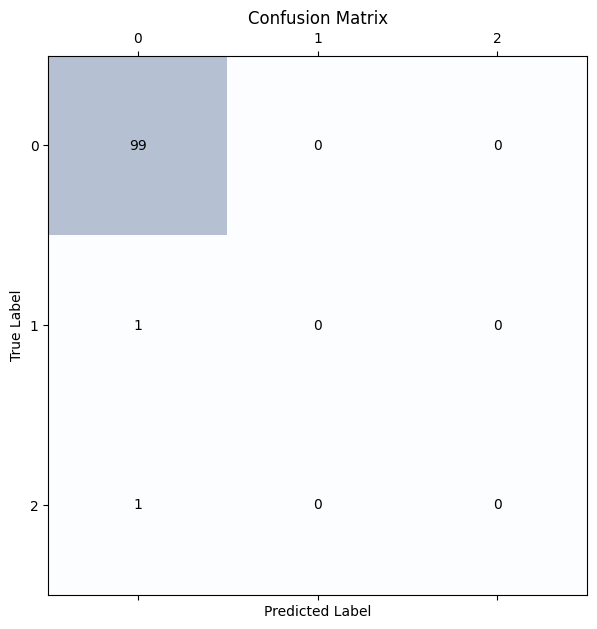

Length of sentiment array: 101

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        99
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1

    accuracy                           0.98       101
   macro avg       0.33      0.33      0.33       101
weighted avg       0.96      0.98      0.97       101



c:\Users\Joseph Rivera\Desktop\project\AI_projects\ml_poc\ml_poc\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Joseph Rivera\Desktop\project\AI_projects\ml_poc\ml_poc\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Joseph Rivera\Desktop\project\AI_projects\ml_poc\ml_poc\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [686]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the training set
y_pred_train = model.predict(train_data)

# Convert probabilities to class labels
y_pred_train = np.argmax(y_pred_train, axis=1)

# Ensure train_labels are in the same format
if len(labels_train.shape) > 1 and labels_train.shape[1] > 1:
    train_labels = np.argmax(labels_train, axis=1)

# Generate confusion matrix
confmat = confusion_matrix(y_true=labels_train, y_pred=y_pred_train)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print(f"Length of sentiment array: {len(y_pred_train)}")
print("\nClassification Report:\n")
print(classification_report(labels_train, y_pred_train))

In [687]:
def predict_and_display_comments(comments, data, model, positive_threshold=0.8, negative_threshold=0.5):
    predictions = model.predict(data)
    
    # Prepare results list
    results = []

    # Process each comment's prediction
    for i, (comments, predictions) in enumerate(zip(comments, predictions)):
        negative_prob, neutral_prob, positive_prob = predictions
        
        # Determine sentiment using thresholds
        if positive_prob >= positive_threshold:
            sentiment = 'Positive'
        elif negative_prob >= negative_threshold:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        
        # Collect the result
        results.append({
            "Predicted_Sentiment": sentiment,
            "Positive_Prob": positive_prob,
            "Neutral_Prob": neutral_prob,
            "Negative_Prob": negative_prob
        })
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    
    return df_results

# Usage
df_pred = predict_and_display_comments(comments=train_data, data=train_data, model=model)
# Ensure that df_pred has the same index as test_df
df_pred.index = train_df.index
df_2 = train_df.join(df_pred)
df_2.head()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup,Year,Month,Quarter,Sentiment,Sentiment_int,Predicted_Sentiment,Positive_Prob,Neutral_Prob,Negative_Prob
0,@freewrytin God is way too good for Claritin,'1',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0,Negative,0.005603,0.006045,0.988352
110,How do you freakin take the cotton ball out of...,'111',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,1,0,Outbound,A,2023,1,1,Negative,0,Negative,0.006430,0.006924,0.986647
88,My grandma is worried about me bringing Clarit...,'89',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0,Negative,0.008013,0.008609,0.983378
44,Chasing a claritin-d with a cran &amp; vodka i...,'45',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,2,0,Outbound,A,2023,1,1,Negative,0,Negative,0.006050,0.006519,0.987431
22,@HannahBlackwell do CLARITIN - D It did wonder...,'23',2023-01-01,Alice Wonderland,Dina Tuto,Scarlet Phillips,3,0,Outbound,A,2023,1,1,Negative,0,Negative,0.005709,0.006155,0.988137


In [688]:
df_2.shape

(101, 19)

<h4 style="color:red;">Testing Data</h4>

In [689]:
data_test, labels_test, tokenizer = preprocess_text_data(test_df, 'Comments', 'Sentiment_int', vocab_size=vocab_size, max_length=max_length)

In [690]:
test_data = preprocess_data(data_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Joseph Rivera\Desktop\project\AI_projects\ml_poc\ml_poc\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


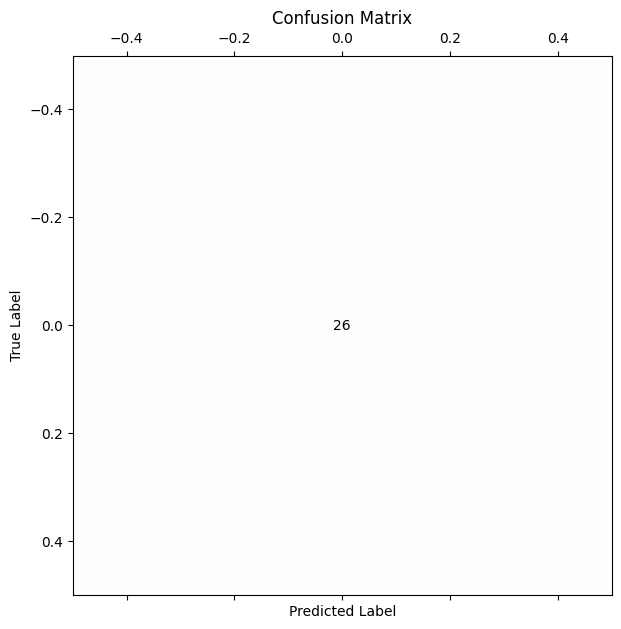

Length of predicted array: 26

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



In [691]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
y_pred_test = model.predict(test_data)

# Convert probabilities to class labels
y_pred_test = np.argmax(y_pred_test, axis=1)

# Ensure labels_test is in the same format as y_pred_test
if len(labels_test.shape) > 1 and labels_test.shape[1] > 1:
    labels_test = np.argmax(labels_test, axis=1)

# Generate confusion matrix
confmat = confusion_matrix(y_true=labels_test, y_pred=y_pred_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print(f"Length of predicted array: {len(y_pred_test)}")
print("\nClassification Report:\n")
print(classification_report(labels_test, y_pred_test))

In [692]:
# y_df_mod = model.predict(test_data)
# y_pred_train = np.round(y_df_mod).astype(int)  # Convert probabilities to binary labels

In [693]:
# positive_threshold = 0.8  # Adjust this threshold as needed
# negative_threshold = 0.5  # Adjust this threshold as needed
# def predict_and_display_reviews(comments):
#     predictions = model.predict(test_data)
#     print(predictions.shape)
    
#     # Assuming predictions output probabilities for [Negative, Neutral, Positive]
#     for i, review in enumerate(comments):
#         # print(f"Comments {i+1}: {comments}")
#         # print(f'Predicted Score: {predictions[i]}')
        
#         negative_prob, neutral_prob, positive_prob = predictions[i]
        
#         # Determine sentiment based on the highest probability
#         if positive_prob >= neutral_prob and positive_prob >= negative_prob:
#             sentiment = 'Positive'
#         elif neutral_prob > positive_prob and neutral_prob > negative_prob:
#             sentiment = 'Neutral'
#         else:
#             sentiment = 'Negative'
        
#         print(f"Review {i+1}: {review}")
#         print(f'Predicted Score: {predictions[i]}')
#         print(f"Predicted Sentiment: {sentiment}")
#         print(f"Probability - Positive: {positive_prob:.2f}")
#         print(f"Probability - Neutral: {neutral_prob:.2f}")
#         print(f"Probability - Negative: {negative_prob:.2f}")
#         print("--------------------------------------------------------------------------------\n")

# # Example usage
# predict_and_display_reviews(test_data)

In [694]:
def predict_and_display_comments(comments, data, model, positive_threshold=0.8, negative_threshold=0.5):
    predictions = model.predict(data)
    
    # Prepare results list
    results = []

    # Process each comment's prediction
    for i, (comments, predictions) in enumerate(zip(comments, predictions)):
        negative_prob, neutral_prob, positive_prob = predictions
        
        # Determine sentiment using thresholds
        if positive_prob >= positive_threshold:
            sentiment = 'Positive'
        elif negative_prob >= negative_threshold:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        
        # Collect the result
        results.append({
            "Predicted_Sentiment": sentiment,
            "Positive_Prob": positive_prob,
            "Neutral_Prob": neutral_prob,
            "Negative_Prob": negative_prob
        })
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    
    return df_results

# Usage
df_pred = predict_and_display_comments(comments=test_data, data=test_data, model=model)
df_pred.index = test_df.index
df_combined = test_df.join(df_pred)
df_combined.tail()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


,Comments,ConversionID,Date,Claim Manager,Service Manager,Officer Name,NPS Score,FCR Score,Initial Direction,Workgroup,Year,Month,Quarter,Sentiment,Sentiment_int,Predicted_Sentiment,Positive_Prob,Neutral_Prob,Negative_Prob
21,@erik_your_angel Get Louise some Claritin.,'22',2024-11-10,Diana Medoza,Dina Tuto,Royalty Foster,3,72,Outbound,D,2024,11,4,Negative,0,Negative,0.005483,0.005917,0.988600
43,Just what I need. Stupid allergies #claritin #...,'44',2024-11-10,Diana Medoza,Dina Tuto,Royalty Foster,3,72,Outbound,D,2024,11,4,Negative,0,Negative,0.006062,0.006537,0.987400
87,@MoreThymeBlog Hi! Good day today. Took 1/2 of...,'88',2024-11-10,Diana Medoza,Dina Tuto,Royalty Foster,3,72,Outbound,D,2024,11,4,Negative,0,Negative,0.008015,0.008611,0.983374
109,FREE Claritin for Children (or Adults) at CVS ...,'110',2024-11-10,Diana Medoza,Dina Tuto,Royalty Foster,2,72,Outbound,D,2024,11,4,Negative,0,Negative,0.006068,0.006537,0.987395
131,@JonathanRKnight If its in your head Zyrtec is...,'132',2024-11-10,Diana Medoza,Dina Tuto,Royalty Foster,3,72,Outbound,D,2024,11,4,Negative,0,Negative,0.007401,0.007960,0.984639


In [695]:
df_combined.shape

(26, 19)